In [1]:
%matplotlib inline
import contextily as cx
import flopy
import matplotlib.pyplot as plt
import numpy as np
import pathlib as pl
import time

In [2]:
cx_provider = cx.providers.USGS.USTopo

In [3]:
def get_flow(bobj, totim):
    Q = bobj.get_data(text="SFR", totim=totim)[0]["q"].sum()
    Q += bobj.get_data(text="DRN", totim=totim)[0]["q"].sum()
    Q += bobj.get_data(text="EVTA", totim=totim)[0]["q"].sum()
    return Q

In [4]:
ws = pl.Path("mf6_transient_base")

In [5]:
sim = flopy.mf6.MFSimulation.load(sim_ws=ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package rch...
    loading package chd...
    loading package evt...
    loading package drn...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package ic...
    loading package sfr...
  loading solution package sp_mf6...


In [6]:
gwf = sim.get_model()

In [7]:
gwf.modelgrid.set_coord_info(xoff=529999.38, yoff=3420183.60, angrot=0, crs="EPSG:26912")
gwf.modelgrid

xll:529999.38; yll:3420183.6; rotation:0; crs:EPSG:26912; units:meters; lenuni:2

In [8]:
extent = gwf.modelgrid.extent

Add well file for perturbation

In [9]:
ca_wel = flopy.mf6.ModflowGwfwel(gwf, maxbound=1, pname="ca_well")

In [10]:
gwf.get_package_list()

['DIS',
 'RCH-1',
 'CHD-1',
 'EVT-1',
 'DRN-1',
 'OC',
 'NPF',
 'STO',
 'IC',
 'SFR-1',
 'CA_WELL']

Change workspace and write files

In [11]:
new_ws = pl.Path("capture_analysis")
sim.set_sim_path(new_ws)
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package sp_mf6...
  writing model sp_mf6...
    writing model name file...
    writing package dis...
    writing package rch-1...
    writing package chd-1...
    writing package evt-1...
    writing package drn-1...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package ic...
    writing package sfr-1...
    writing package ca_well...


In [12]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../miniforge3/envs/develop/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/23/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Feb 23 2024 13:02:30 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use

(True, [])

In [13]:
hobj = gwf.output.head()

In [14]:
times = hobj.get_times()
times[0], times[-1]

(365.25, 3652.5)

In [15]:
hds = hobj.get_data(totim=times[-1])

In [16]:
cobj = gwf.output.budget()

In [17]:
cobj.get_unique_record_names()

[b'          STO-SS',
 b'          STO-SY',
 b'    FLOW-JA-FACE',
 b'      DATA-SPDIS',
 b'             WEL',
 b'             DRN',
 b'            RCHA',
 b'           EVTA ',
 b'             CHD',
 b'             SFR']

In [18]:
spdis = cobj.get_data(text="DATA-SPDIS", totim=times[-1])[0]
spdis
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf, head=hds)

In [19]:
mosaic = [
    ["a", "b"], ["a", "b"], ["a", "b"], ["a", "b"], ["a", "b"],
    ["a", "b"], ["a", "b"], ["a", "b"], ["a", "b"], ["a", "b"],
    ["c", "c"],
]

In [20]:
plt_ratio = float(gwf.modelgrid.nrow) / float(gwf.modelgrid.ncol)
plt_ratio

1.375

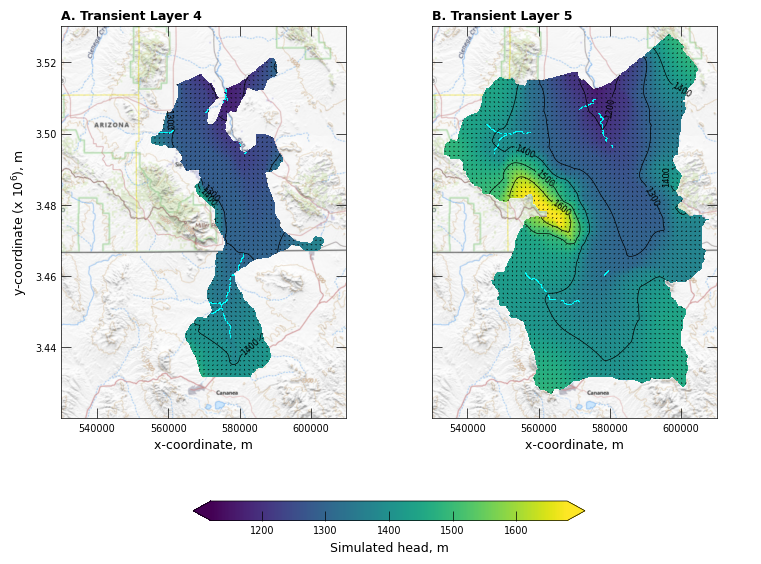

In [21]:
vmin, vmax = 1120, 1680
levels = [1200, 1300, 1400, 1500, 1600]
width = 7.5
height = (plt_ratio + 0.1) * (width / 2)
with flopy.plot.styles.USGSPlot():
    fig, axs = plt.subplot_mosaic(mosaic, sharey=True, figsize=(width, height), layout="constrained")
          
    ax = axs["a"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    ax.yaxis.offsetText.set_visible(False)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=3, extent=gwf.modelgrid.extent)
    cx.add_basemap(ax, crs=gwf.modelgrid.crs, attribution=False, source=cx_provider)
    mm.plot_array(hds, vmin=vmin, vmax=vmax)
    mm.plot_bc("SFR", color="cyan")
    mm.plot_vector(qx, qy, istep=5, jstep=5, normalize=True)
    cs = mm.contour_array(hds, levels=levels, colors="black", linewidths=0.5)
    ax.clabel(cs, cs.levels, inline=True, fmt="%1.0f", fontsize=6, inline_spacing=1)
    flopy.plot.styles.heading(ax=ax, idx=0, heading="Transient Layer 4")
    flopy.plot.styles.xlabel(ax=ax, label="x-coordinate, m")
    flopy.plot.styles.ylabel(ax=ax, label="y-coordinate (x 10$^6$), m")

    ax = axs["b"]
    ax.set_xlim(gwf.modelgrid.extent[0:2])
    ax.set_ylim(gwf.modelgrid.extent[2:])
    ax.yaxis.offsetText.set_visible(False)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=4)
    cx.add_basemap(ax, crs=gwf.modelgrid.crs, attribution=False, source=cx_provider)
    v = mm.plot_array(hds, vmin=vmin, vmax=vmax)
    mm.plot_bc("SFR", color="cyan")
    mm.plot_vector(qx, qy, istep=5, jstep=5, normalize=True)
    cs = mm.contour_array(hds, levels=levels, colors="black", linewidths=0.5)
    ax.clabel(cs, cs.levels, inline=True, fmt="%1.0f", fontsize=6, inline_spacing=1)
    flopy.plot.styles.heading(ax=ax, idx=1, heading="Transient Layer 5")
    flopy.plot.styles.xlabel(ax=ax, label="x-coordinate, m")

    ax = axs["c"]
    ax.axis("off")
    cbar = plt.colorbar(v, ax=ax, orientation="horizontal", extend="both", ticks=levels, fraction=0.5)
    cbar.ax.set_xlabel("Simulated head, m", rotation=0)
    fig.savefig("results_trans.png", dpi=300)

### Get base stream baseflow

In [22]:
Q_base = get_flow(cobj, times[-1])
Q_base

-55421.09342919642

In [23]:
nlay, nrow, ncol = gwf.dis.nlay.array, gwf.dis.nrow.array, gwf.dis.ncol.array
nlay, nrow, ncol

(5, 440, 320)

In [24]:
idomain = gwf.dis.idomain.array
idomain.shape

(5, 440, 320)

In [25]:
cf = np.full((nlay, nrow, ncol), -1.0, dtype=float)

In [26]:
k = 3
dq = -10.0

In [27]:
sample = 2 # calculate cf for every sample location
sample_arr = np.array([sample])
ilocs = []
for i in range(0, nrow, sample):
    for j in range(0, ncol, sample):
        if idomain[k, i, j] > 0:
            ilocs.append((i, j))
ilocs = np.array(ilocs)

In [28]:
total_cells = ilocs.shape[0]
total_cells

6110

In [29]:
cf_path = "capture_fraction_transient.npz"

In [30]:
t0 = time.perf_counter()
for idx, (i,j) in enumerate(ilocs):
   
    gwf.ca_well.stress_period_data = {0: [(k, i, j, dq)]}
    gwf.ca_well.write()
    
    sim.run_simulation(silent=True)
    Q = get_flow(gwf.output.budget(), times[-1])
    
    fraction = abs(Q - Q_base) / abs(dq)
    cf[k, i, j] = fraction

    progress = (idx + 1) / total_cells    
    message = (
        f"Location: ({idx:5d}) ({k}, {i:3d}, {j:3d}) " + 
        f"Capture fraction: {fraction: 5.3f} " + 
        f"Percent complete: {progress:7.3%} " + 
        f"Run time: {(time.perf_counter() - t0)/60:9.4f} minutes"
    )
    print(message, end="\r")

    if idx % 10 == 0:
        np.savez_compressed(cf_path, capture_fraction=cf, sample_size=sample_arr)

t1 = time.perf_counter()
print(f"\n\nSimulation time: {(t1 - t0)/3600. :9.4f} hours")

Location: ( 6109) (3, 392, 212) Capture fraction:  0.000 Percent complete: 100.000% Run time:  681.0896 minutes

Simulation time:   11.3515 hours


In [31]:
np.savez_compressed(cf_path, capture_fraction=cf, sample_size=sample_arr)